In [32]:
import sys
import os
import time
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

%matplotlib inline

In [33]:
def splitData(data, split):  
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    length_train_data = int(split * len(data))
    train_data = data[:length_train_data]
    test_data = data[length_train_data:]
    
    return [train_data, test_data]

In [34]:
def get_length_bin(length):
    return round(length / 10)

def get_score(result):
    return 1 if result else 0

def prepereDataForPlot(result_df):
    result_df['correct_guess'] = result_df['detectedEmotion'] == result_df['emotion']
    result_df['score'] = map(get_score, result_df['correct_guess'])
    #create group with 10 elements
    result_df['text_length_bin'] = map(get_length_bin, result_df['words'])    
    return result_df

In [35]:
def createPlotByScore(data):
    grouped = data.groupby('words', as_index=False)['score'].mean()
    fig, ax = plt.subplots()
    x = grouped.words
    y = grouped.score
    fit = np.polyfit(x, y, deg=1)
    ax.plot(x, fit[0] * x + fit[1], color='red')
    ax.scatter(x, y)
    
    plt.xlabel('Lenght of text')
    plt.ylabel('Efficacy')
    
    fig.show()

In [36]:
#zaleznosc oceny od wykrytej emocji
def createPlotByRate(data):
    data = data.round({'rate': 0})   
    grouped = data.groupby('rate', as_index=False)['score'].mean()
    fig, ax = plt.subplots()
    x = grouped.rate
    y = grouped.score
    fit = np.polyfit(x, y, deg=1)
    ax.plot(x, fit[0] * x + fit[1], color='red')
    ax.scatter(x, y)
    
    plt.xlabel('Rate')
    plt.ylabel('Efficacy')

    fig.show()

In [37]:
def getResults(result_df):
    return result_df.groupby('correct_guess').size()

In [38]:
def removeChars(text):
    return re.sub("[!#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~']", '', text)

In [39]:
def prepereData(comments):  
    data = np.empty((0))
    data_labels = np.empty((0))
  
    for index, train_data in comments.iterrows():
        data = np.append(data, train_data['text'])
        data_labels = np.append(data_labels, train_data['emotion'])
    return [data, data_labels]

In [40]:
def SVM_liblinear(iterations, dataset, is_shuffle):
    data = dataset[0]
    data_labels = dataset[1]
    
    sss = StratifiedKFold(n_splits=iterations, shuffle=is_shuffle)

    for train_index, test_index in sss.split(data, data_labels):
        train_data = data[train_index]
        train_labels = data_labels[train_index]
        
        vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
        train_vectors = vectorizer.fit_transform(train_data)
        
        classifier_liblinear = svm.LinearSVC()
        classifier_liblinear.fit(train_vectors, train_labels)
        
    return [classifier_liblinear,vectorizer]

In [41]:
def SCV_detectingEmotions(classifier, vectorizer, test_data):
    test_vectors = vectorizer.transform(test_data)
    prediction_liblinear = classifier.predict(test_vectors)
    return prediction_liblinear

In [54]:
#testing dataset
data = pd.read_csv('mediaKrytyk-comments-analysis-dictParser.csv')
data.reset_index()
[train_data, test_data] = splitData(data, 0.8)
test_data = test_data.reset_index()

test_data['text'] = map(removeChars, test_data['text'])
train_data['text'] = map(removeChars, train_data['text'])

test_data['lemmatisation'] = map(removeChars, test_data['lemmatisation'])
train_data['lemmatisation'] = map(removeChars, train_data['lemmatisation'])

train_data = prepereData(train_data)
[classifier, vectorizer] = SVM_liblinear(10, train_data, True)
detectedEmotion = SCV_detectingEmotions(classifier,vectorizer,test_data['lemmatisation'])

result_slowosiec = pd.DataFrame({"text": test_data['text'], "detectedEmotion": test_data['detectedEmotion'], 'emotion': test_data['emotion'], 'rate': test_data['rate'], 'words': test_data['words']})
result_svm = pd.DataFrame({"text": test_data['text'], "detectedEmotion": detectedEmotion, 'emotion': test_data['emotion'], 'rate': test_data['rate'], 'words': test_data['words']})

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [58]:
result_svm = prepereDataForPlot(result_svm)
getResults(result_svm)

correct_guess
False    366
True     849
dtype: int64

In [49]:
result_slowosiec = prepereDataForPlot(result_slowosiec)
getResults(result_slowosiec)

correct_guess
False    576
True     639
dtype: int64

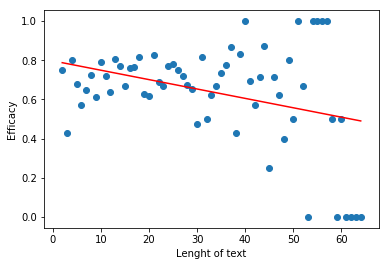

In [56]:
createPlotByScore(result_svm)

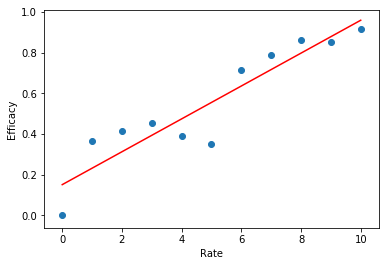

In [59]:
createPlotByRate(result_svm)

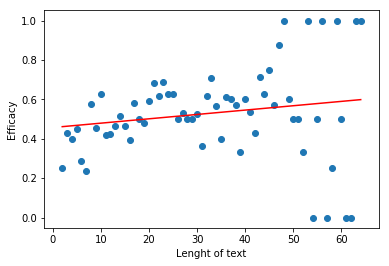

In [52]:
createPlotByScore(result_slowosiec)

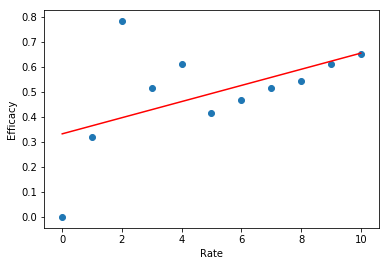

In [53]:
createPlotByRate(result_slowosiec)